# SQL con Python

## Imports iniciales

In [1]:
import numpy as np
import pandas as pd
import sqlite3 # <-- Interactuar con BD SQLite
import matplotlib.pyplot as plt
%matplotlib inline

# Crear una conexión a la BD

In [2]:
conn = sqlite3.connect("chinook.sqlite"); conn

## Querys

Una vez conectados a la BD SQLite es posible hacer querys de sql directamente desde el Jupyter Notebook.

### Existen dos maneras de hacer un query:

# Query SQL

Definir el query y almacenarlo en una variable y ejecutarlo hacia la conexión.

In [3]:
sql = """
select al.Title, ar.Name
from albums al
inner join artists ar on ar.ArtistId = al.ArtistId
order by al.Title asc
limit 3
"""
pd.read_sql_query(sql, conn)

,Title,Name
0,...And Justice For All,Metallica
1,20th Century Masters - The Millennium Collecti...,Scorpions
2,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra


# Manipulación mediante Pandas

Crear sub-dataframes a partir de pequeños querys

In [4]:
df1 = pd.read_sql_query("select * from albums", conn); df1.head(2)

,AlbumId,Title,ArtistId
0,1,For Those About To Rock We Salute You,1
1,2,Balls to the Wall,2


In [5]:
df2 = pd.read_sql_query("select * from artists", conn); df2.head(2)

,ArtistId,Name
0,1,AC/DC
1,2,Accept


In [6]:
df1.merge(df2, on='ArtistId')[['Title', 'Name']].sort_values(by='Title')[:3].reset_index().iloc[:,-2:]

,Title,Name
0,...And Justice For All,Metallica
1,20th Century Masters - The Millennium Collecti...,Scorpions
2,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra


# Gráficos

In [8]:
df3 = pd.read_sql_query("select * from invoices", conn); df3.head()

,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,1,2,2009-01-01 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,1.98
1,2,4,2009-01-02 00:00:00,Ullevålsveien 14,Oslo,None,Norway,0171,3.96
2,3,8,2009-01-03 00:00:00,Grétrystraat 63,Brussels,None,Belgium,1000,5.94
3,4,14,2009-01-06 00:00:00,8210 111 ST NW,Edmonton,AB,Canada,T6G 2C7,8.91
4,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86


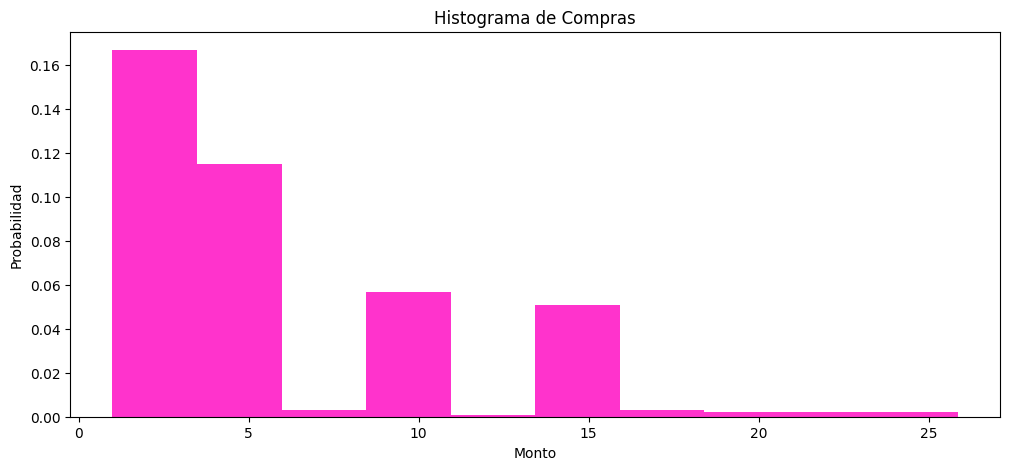

In [9]:
plt.figure(figsize=(12,5))
plt.hist(df3.Total, density=True, color='#ff33cc')
plt.title('Histograma de Compras')
plt.xlabel('Monto')
plt.ylabel('Probabilidad');

# Agrupación con SQL

In [10]:
sql = """
select BillingCountry as Country, sum(Total) as Amount
from invoices
group by BillingCountry
having Amount > 100
"""
pd.read_sql_query(sql, conn)

,Country,Amount
0,Brazil,190.10
1,Canada,303.96
2,France,195.10
3,Germany,156.48
4,USA,523.06
5,United Kingdom,112.86


# Agrupación con Pandas

In [11]:
df3.groupby('BillingCountry').sum()[['Total']].query('Total > 100').reset_index().rename(columns={"BillingCountry": "Country", "Total": "Amount"})

C:\Users\JJIMENEZG\AppData\Local\Temp\ipykernel_1700\2941208778.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3.groupby('BillingCountry').sum()[['Total']].query('Total > 100').reset_index().rename(columns={"BillingCountry": "Country", "Total": "Amount"})


,Country,Amount
0,Brazil,190.10
1,Canada,303.96
2,France,195.10
3,Germany,156.48
4,USA,523.06
5,United Kingdom,112.86


# Datos de tiempo

In [12]:
# Revisar el tipo de dato por columna
df3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   InvoiceId          412 non-null    int64  
 1   CustomerId         412 non-null    int64  
 2   InvoiceDate        412 non-null    object 
 3   BillingAddress     412 non-null    object 
 4   BillingCity        412 non-null    object 
 5   BillingState       210 non-null    object 
 6   BillingCountry     412 non-null    object 
 7   BillingPostalCode  384 non-null    object 
 8   Total              412 non-null    float64
dtypes: float64(1), int64(2), object(6)
memory usage: 29.1+ KB


InvoiceDate contiene información sobre el día y la hora, sin embargo es una cadena de caracteres $(string)$

In [13]:
df3.InvoiceDate

0      2009-01-01 00:00:00
1      2009-01-02 00:00:00
2      2009-01-03 00:00:00
3      2009-01-06 00:00:00
4      2009-01-11 00:00:00
              ...         
407    2013-12-05 00:00:00
408    2013-12-06 00:00:00
409    2013-12-09 00:00:00
410    2013-12-14 00:00:00
411    2013-12-22 00:00:00
Name: InvoiceDate, Length: 412, dtype: object

### Cambiar el tipo de datos de string a $datetime$

In [14]:
pd.to_datetime(df3.InvoiceDate)

0     2009-01-01
1     2009-01-02
2     2009-01-03
3     2009-01-06
4     2009-01-11
         ...    
407   2013-12-05
408   2013-12-06
409   2013-12-09
410   2013-12-14
411   2013-12-22
Name: InvoiceDate, Length: 412, dtype: datetime64[ns]

In [15]:
df3['InvoiceDate'] = pd.to_datetime(df3.InvoiceDate) #guardar en columna InvoiceDate

In [16]:
df3.info() #Confirmar el tipo de dato $DateTime$

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   InvoiceId          412 non-null    int64         
 1   CustomerId         412 non-null    int64         
 2   InvoiceDate        412 non-null    datetime64[ns]
 3   BillingAddress     412 non-null    object        
 4   BillingCity        412 non-null    object        
 5   BillingState       210 non-null    object        
 6   BillingCountry     412 non-null    object        
 7   BillingPostalCode  384 non-null    object        
 8   Total              412 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 29.1+ KB


### El tipo de datos DateTime permite realizar operaciones numéricas

Por ejemplo, obtener los estadísticos descriptivos

In [17]:
df3.InvoiceDate.describe(datetime_is_numeric=True)

count                              412
mean     2011-06-26 08:05:49.514563072
min                2009-01-01 00:00:00
25%                2010-03-27 00:00:00
50%                2011-06-22 12:00:00
75%                2012-09-26 06:00:00
max                2013-12-22 00:00:00
Name: InvoiceDate, dtype: object

Encontrar fechas mas recuientes a un día en específico (1 de Enero de 2011)

In [18]:
df3.InvoiceDate > '2011-01-01'

0      False
1      False
2      False
3      False
4      False
       ...  
407     True
408     True
409     True
410     True
411     True
Name: InvoiceDate, Length: 412, dtype: bool

Encontrar fechas entre dos días en específico (1 de Enero de 2009 y 1 de Junio de 2009)

In [19]:
df3.InvoiceDate.between('2009-01-01', '2009-06-01')

0       True
1       True
2       True
3       True
4       True
       ...  
407    False
408    False
409    False
410    False
411    False
Name: InvoiceDate, Length: 412, dtype: bool

A finalizar la sesión es necesario terminar la conexión para detener la interacción con la BD

# Terminar la conexión

In [20]:
conn.close()